<a href="https://colab.research.google.com/github/rycho65/Biocondensate-Heterogeneity/blob/main/code_for_biocondensate_clustering_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below code is an unsupervised learning pipeline that focuses on using heirarchical clustering aided with PCA for visualization

This step is creating the a table of features using RegionProps. Input is CSV file that resembles an image with lifetime as the boxes.

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from skimage import measure, filters

from google.colab import drive
drive.mount('/content/drive')

# this alpha is basically how strong the high lifetime spots are pulling. So the higher the number the more pull those red spots will have.
ALPHA = 5

# this step is establishing my folder and then looping through all the contents of the folder that ends with 'csv'.
my_folder = "/content/drive/MyDrive/roi_files"
csv_files = glob.glob(os.path.join(my_folder, "*.csv"))

# this is the important extraction part where you taking out the features using RegionProps
def extract_features_from_csv(csv_file):

    try:
        roi = pd.read_csv(csv_file, header=None).values.astype(float)

        if np.all(roi == 0):
            print(f"Skipped (all zeros): {csv_file}")
            return None

        # Threshold is the minimum value to be considered a signal. And additionally the otsu is bascially the automatic system to determine what value that should be.
        try:
            threshold = filters.threshold_otsu(roi)
        except:
            threshold = roi.mean()

        # you unfortunately have to consider the lifeimte as intensity here
        mask = roi > threshold
        labeled = measure.label(mask)
        props = measure.regionprops(labeled, intensity_image=roi)

        # if no regions that are above the threshold then just tell me that nothing is there
        if not props:
            print(f"Skipped (no regions): {csv_file}")
            return None

        # basically just the main roi area
        region = max(props, key=lambda r: r.area)
        region_mask = labeled == region.label

        from skimage.measure import shannon_entropy

        # Compute texture entropy on the intensity image of the region.... shannon entropy equation is used, then normalized
        entropy = shannon_entropy(region.intensity_image)
        entropy_per_pixel = entropy / region.area if region.area > 0 else 0

        # just finding perimeter and using the formula to find the sphericity... just math
        perimeter = region.perimeter
        sphericity = (4 * np.pi * region.area) / (perimeter ** 2) if perimeter > 0 else 0
        lifetime_std = np.std(roi[region_mask])

        # this is boudning the ROI so i do not need to cut out and partition it. just use the pure image
        minr, minc, maxr, maxc = region.bbox
        roi_width = maxc - minc
        roi_height = maxr - minr

        # Max-lifetime pixel (relative to bounding box)
        brightest_y, brightest_x = np.unravel_index(np.argmax(roi, axis=None), roi.shape)
        relative_max_lifetime_x = (brightest_x - minc) / (roi_width - 1)
        relative_max_lifetime_y = (brightest_y - minr) / (roi_height - 1)

        # Strong patch metrics (top 10% of lifetimes)
        strong_threshold = np.percentile(roi[region_mask], 90)
        strong_mask = (roi > strong_threshold) & region_mask
        labeled_strong = measure.label(strong_mask, connectivity=2)
        strong_regions = measure.regionprops(labeled_strong)

        strong_patch_area = max([r.area for r in strong_regions], default=0)
        strong_patch_ratio = strong_patch_area / region.area
        num_strong_patches = len(strong_regions)

        # Weighted centroid using alpha
        roi_lifetime_weighted = roi ** ALPHA
        region_weighted = max(
            measure.regionprops(labeled, intensity_image=roi_lifetime_weighted),
            key=lambda r: r.area
        )
        weighted_centroid_x = region_weighted.weighted_centroid[1]
        weighted_centroid_y = region_weighted.weighted_centroid[0]
        relative_weighted_centroid_x = (weighted_centroid_x - minc) / (roi_width - 1)
        relative_weighted_centroid_y = (weighted_centroid_y - minr) / (roi_height - 1)

        features = {
            "filename": os.path.basename(csv_file),
            "area": region.area,
            "mean_lifetime": region.mean_intensity,
            "lifetime_std": lifetime_std,
            "sphericity": sphericity,
            "eccentricity": region.eccentricity,
            "solidity": region.solidity,
            "strong_patch_ratio": strong_patch_ratio,
            "num_strong_patches": num_strong_patches,
            "centroid_x": region.centroid[1],
            "centroid_y": region.centroid[0],
            "relative_centroid_x": (region.centroid[1] - minc) / (roi_width - 1),
            "relative_centroid_y": (region.centroid[0] - minr) / (roi_height - 1),
            "relative_max_lifetime_x": relative_max_lifetime_x,
            "relative_max_lifetime_y": relative_max_lifetime_y,
            "relative_weighted_lifetime_centroid_x": relative_weighted_centroid_x,
            "relative_weighted_lifetime_centroid_y": relative_weighted_centroid_y,
            "centroid_shift": np.linalg.norm(np.array(region.centroid) - np.array(region.weighted_centroid)),
            "normalized_centroid_shift": np.linalg.norm(np.array(region.centroid) - np.array(region.weighted_centroid)) / np.sqrt(region.area),
            "entropy_per_pixel": entropy_per_pixel,
            "strong_patch_density": num_strong_patches/region.area
        }

        return features

    except Exception as e:
        print(f"Error processing {csv_file}: {e}")
        return None

feature_list = [extract_features_from_csv(f) for f in csv_files]
feature_list = [f for f in feature_list if f is not None]

features_df = pd.DataFrame(feature_list)
features_df.to_csv("/content/drive/MyDrive/rc_important_features.csv", index=False)


Mounted at /content/drive


This step is just making sure the order of the CSV is right and numerical

In [ ]:
import pandas as pd
import re

df = pd.read_csv("/content/drive/MyDrive/rc_important_features.csv")

def extract_numbers(filename):
    matches = re.findall(r"(\d+)", filename)
    if len(matches) >= 2:
        return int(matches[0]), int(matches[1])
    elif len(matches) == 1:
        return int(matches[0]), -1
    else:
        return -1, -1

df[["image_number", "roi_number"]] = df["filename"].apply(lambda x: pd.Series(extract_numbers(x)))

df = df.sort_values(["image_number", "roi_number"]).reset_index(drop=True)

df = df.drop(columns=["image_number", "roi_number", "centroid_x", "centroid_y"])

df.to_csv("/content/drive/MyDrive/rc_ordered_thx.csv", index=False)


this is the pcs plot using the features that we care about. i will select around 6-7

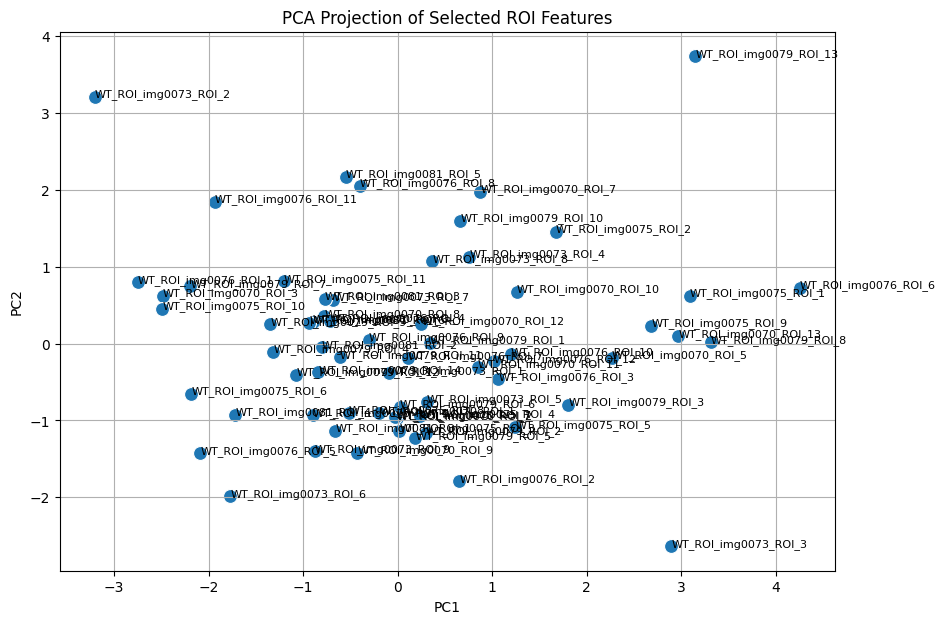

Top contributing features:
                         PC1       PC2
entropy_per_pixel   0.596898  0.009606
sphericity          0.548652  0.224676
num_strong_patches  0.533382  0.030605
lifetime_std        0.231428  0.650616
centroid_shift      0.068111  0.724700


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("/content/drive/MyDrive/rc_ordered_thx.csv")

# this is me selecting the features. if you want to change the features please just edit the variables
selected_features = [
    "lifetime_std",
    "sphericity",
    "centroid_shift",
    "num_strong_patches",
    "entropy_per_pixel"
 ]

# using standard scalar to scale this thing correctly and uniformly
X = df[selected_features]
filenames = df["filename"].tolist()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=100)
for i, name in enumerate(filenames):
    plt.text(X_pca[i, 0], X_pca[i, 1], name.replace(".csv", ""), fontsize=8)
plt.title("PCA Projection of Selected ROI Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Showing top contributing features to the pca itself
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"], index=selected_features)
print("Top contributing features:")
print(loadings.abs().sort_values(by="PC1", ascending=False))


below is a cosine similarity graph

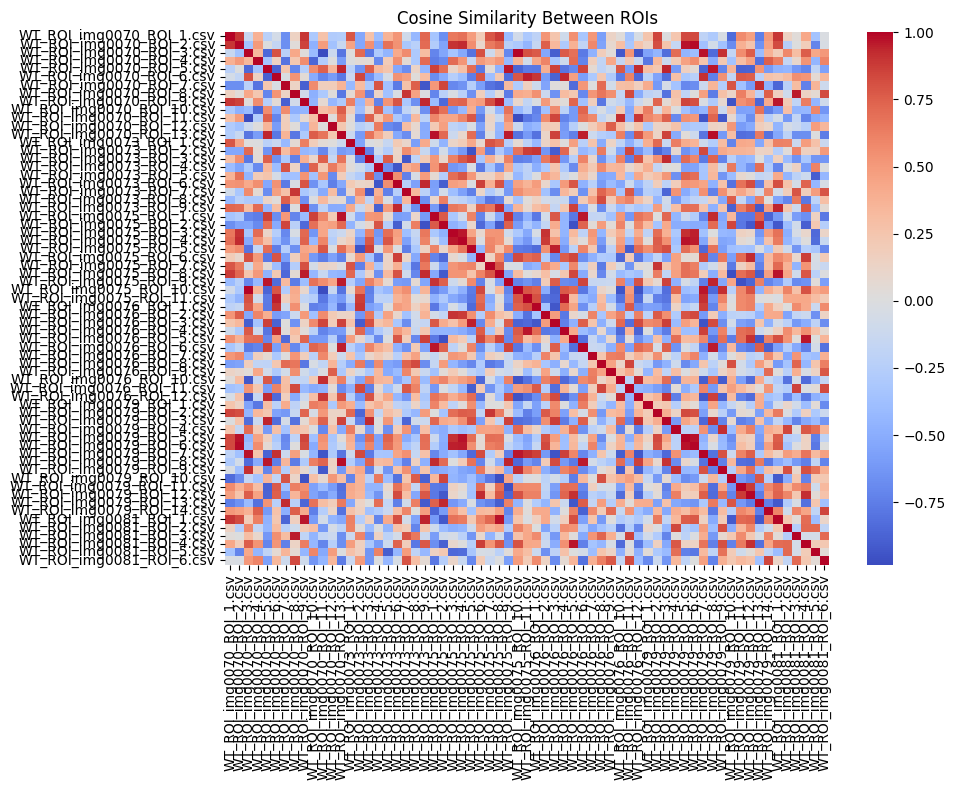

In [ ]:
cos_sim = cosine_similarity(X_scaled)
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, xticklabels=filenames, yticklabels=filenames, cmap="coolwarm", annot=False)
plt.title("Cosine Similarity Between ROIs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

This step is just creating a dendrogram that is using cosine similiarity.

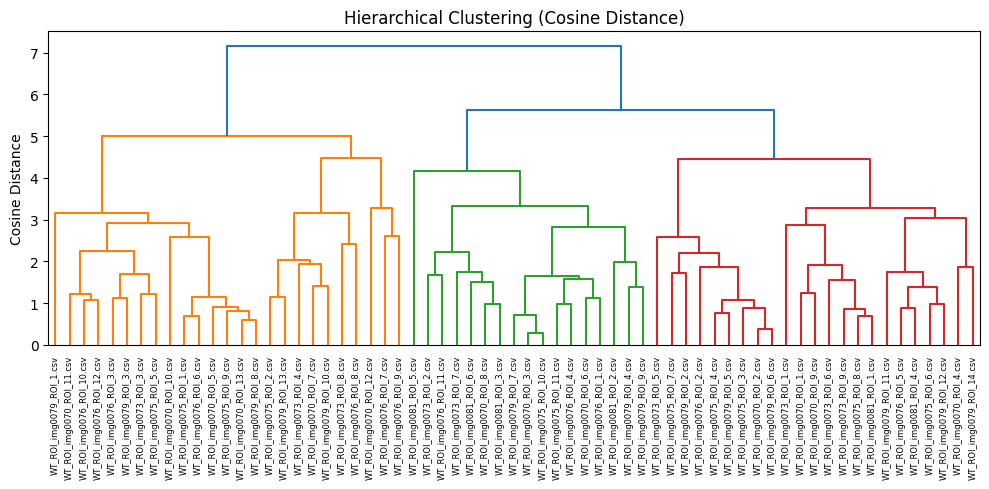

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

cos_dist = 1 - cos_sim

plt.figure(figsize=(10, 5))
dendrogram(linkage(cos_dist, method='average'), labels=filenames, leaf_rotation=90)
plt.title("Hierarchical Clustering (Cosine Distance)")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()

This script is basically creating the PCA plot with nice interactive features. You are able to control the PCA plot using the second paragraph under "fig"

In [ ]:
labels = fcluster(linkage(cos_dist, method='average'), t=5, criterion='maxclust')
df["cluster"] = labels

plotly_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "filename": filenames,
    "cluster": df["cluster"]
})

plotly_df["cluster"] = plotly_df["cluster"].astype(str)


fig = px.scatter(
    plotly_df,
    x="PC1",
    y="PC2",
    color="cluster",
    hover_name="filename",
    title="Interactive PCA Projection by Cluster (Plotly)",
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_traces(marker=dict(size=13))

fig.update_layout(
    width=800,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showline=True, linewidth=2, linecolor='black', showgrid=False, zeroline=False),
    yaxis=dict(
        showline=True,
        linewidth=2,
        linecolor='black',
        showgrid=False,
        zeroline=False
    ),

)


fig.show()

df.to_csv("/content/drive/MyDrive/help.csv", index=False)
fig.write_html("/content/drive/MyDrive/pca_plot.html")


this code just downloads html into browser. will take a bit on slower or older computers.

In [ ]:
fig.write_html("pca_plot.html")

from google.colab import files
files.download("pca_plot.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

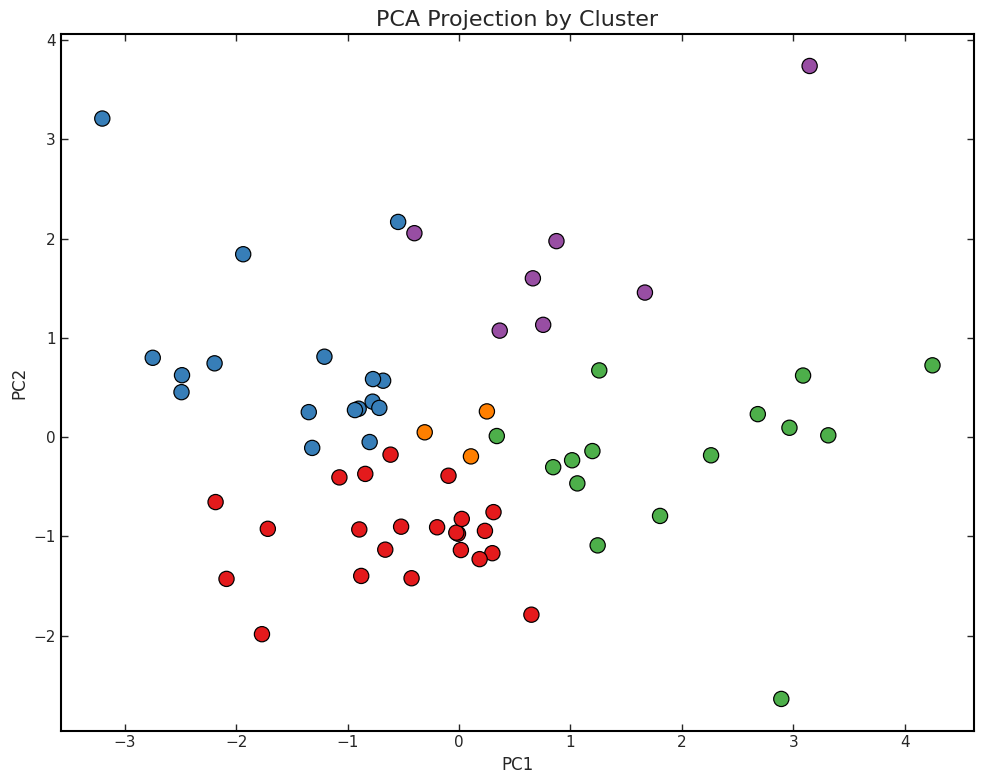

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(style="white")

scatter = sns.scatterplot(
    data=plotly_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set1",
    s=120,
    edgecolor='black'
)


for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tick_params(
    axis='both',
    which='both',
    direction='in',
    length=5,
    width=1,
    bottom=True, top=True, left=True, right=True
)


plt.title("PCA Projection by Cluster", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")

scatter.legend_.remove()


plt.tight_layout()

output_path = "/content/drive/MyDrive/pca_plot_clean_ticks.png"
plt.savefig(output_path, dpi=300)
plt.show()


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/help.csv')

selected_cols = [
    "filename",
    "lifetime_std",
    "sphericity",
    "centroid_shift",
    "num_strong_patches",
    "entropy_per_pixel",
    "cluster",
]

filtered_df = df[selected_cols]

filtered_df.to_csv("/content/drive/MyDrive/filtered_features.csv", index=False)

This script is basically for finding what variables are important for the different cluster types.

In [ ]:
from sklearn.feature_selection import f_classif
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/filtered_features.csv"

df = pd.read_csv(file_path)
X = df.select_dtypes(include=[float, int]).drop(columns=["cluster"])
y = df["cluster"]

f_vals, p_vals = f_classif(X, y)
anova_df = pd.DataFrame({
    "Feature": X.columns,
    "F_score": f_vals,
    "p_value": p_vals
}).sort_values(by="F_score", ascending=False)

print(anova_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
              Feature    F_score       p_value
4   entropy_per_pixel  29.977574  1.035078e-13
1          sphericity  23.396390  1.094300e-11
3  num_strong_patches  15.870671  6.483500e-09
2      centroid_shift  14.939169  1.580656e-08
0        lifetime_std  11.168204  7.753742e-07


Very self explainatory but basically what groups are highest on average for the various features

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/filtered_features.csv"
df = pd.read_csv(file_path)

cluster_means = df.groupby("cluster").mean(numeric_only=True)

rankings = []

for feature in cluster_means.columns:
    sorted_clusters = cluster_means[feature].sort_values(ascending=False)
    ranking_str = " > ".join(str(c) for c in sorted_clusters.index)
    rankings.append({
        "Feature": feature,
        "Cluster Ranking (High → Low)": ranking_str
    })

ranking_df = pd.DataFrame(rankings)
from IPython.display import display
display(ranking_df)

ranking_df.to_csv("/content/drive/MyDrive/cluster_rankings_by_feature.csv", index=False)


,Feature,Cluster Ranking (High → Low)
0,lifetime_std,2 > 1 > 4 > 3 > 5
1,sphericity,1 > 2 > 5 > 3 > 4
2,centroid_shift,2 > 4 > 3 > 1 > 5
3,num_strong_patches,4 > 5 > 3 > 1 > 2
4,entropy_per_pixel,1 > 2 > 3 > 5 > 4


correlation heatmap for the features


Numeric columns found: ['lifetime_std', 'sphericity', 'centroid_shift', 'num_strong_patches', 'entropy_per_pixel', 'cluster']


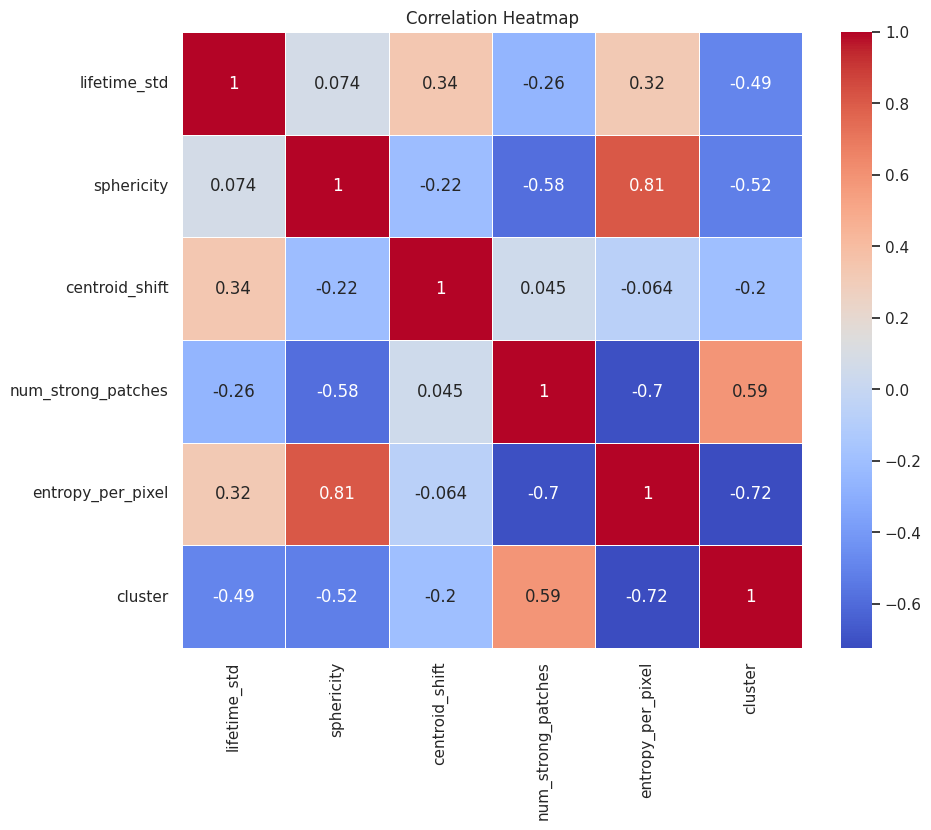

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

file_path = '/content/drive/MyDrive/filtered_features.csv'
df = pd.read_csv(file_path)

num_cols = df.select_dtypes(include='number').columns.tolist()
print(f"\nNumeric columns found: {num_cols}")

plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

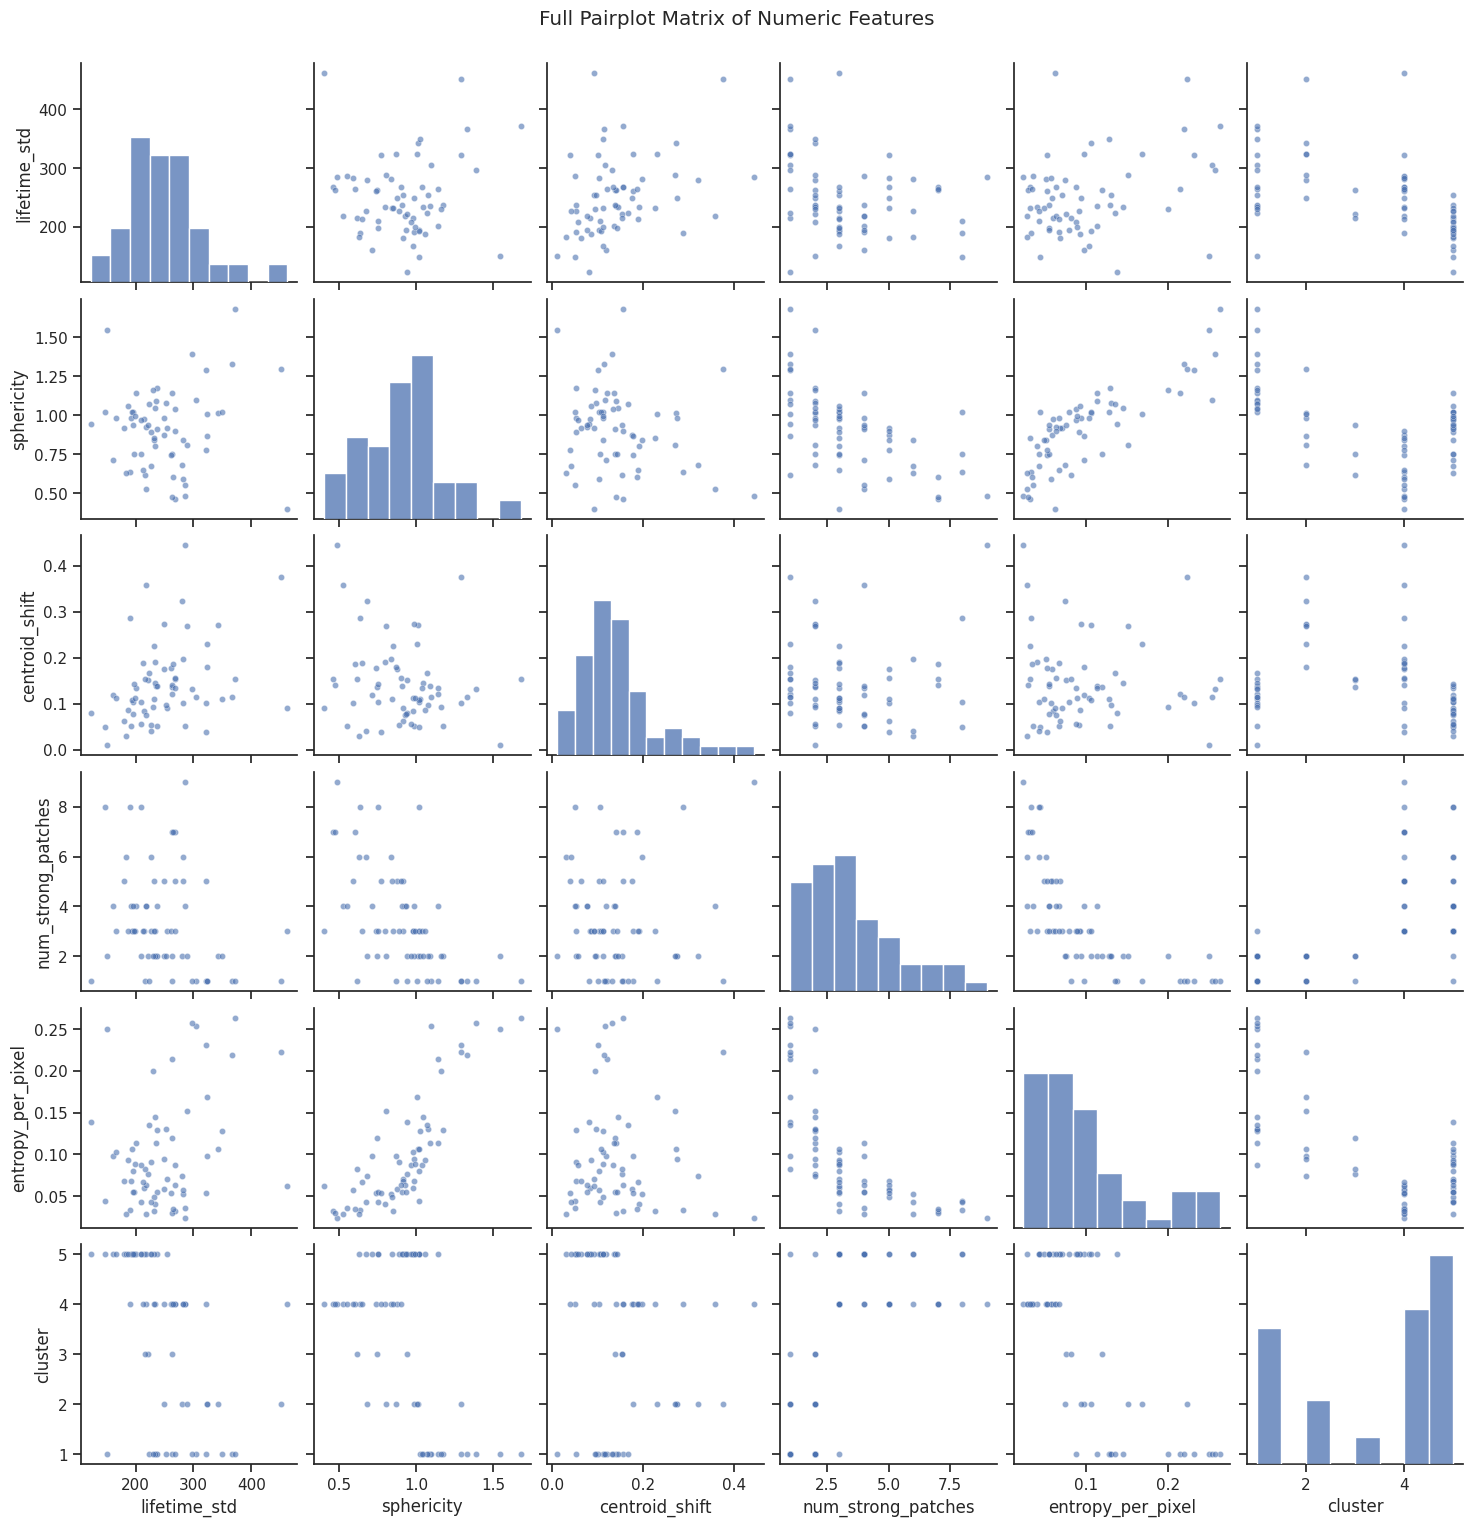

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', color_codes=True)

sns.pairplot(df[num_cols], corner=False, diag_kind='hist', plot_kws={"s": 20, "alpha": 0.6})

plt.suptitle("Full Pairplot Matrix of Numeric Features", y=1.02)
plt.show()

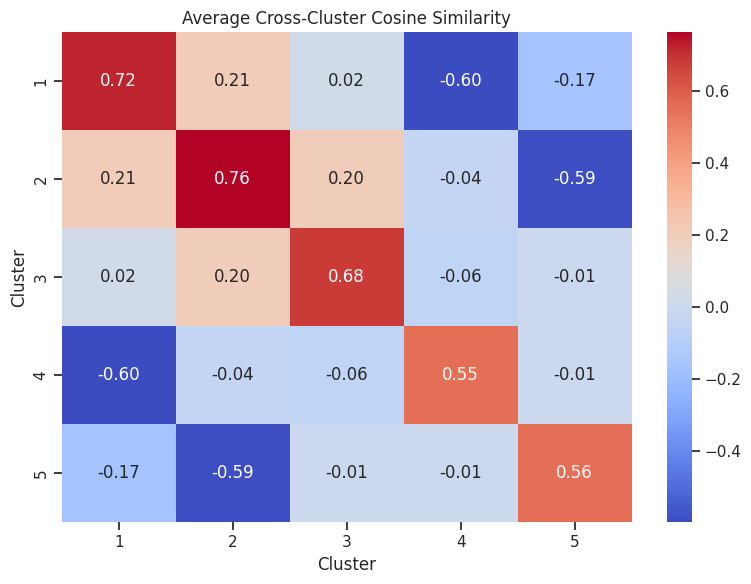

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = df[num_cols].drop(columns='cluster').columns.tolist()
clusters = sorted(df['cluster'].unique())
n = len(clusters)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_cols]), columns=feature_cols)
df_scaled['cluster'] = df['cluster'].values

sim_matrix = np.zeros((n, n))

for i, ci in enumerate(clusters):
    for j, cj in enumerate(clusters):
        group_i = df_scaled[df_scaled['cluster'] == ci].drop(columns='cluster').values
        group_j = df_scaled[df_scaled['cluster'] == cj].drop(columns='cluster').values
        sim = cosine_similarity(group_i, group_j).mean()
        sim_matrix[i, j] = sim

sim_df = pd.DataFrame(sim_matrix, index=clusters, columns=clusters)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Cross-Cluster Cosine Similarity")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


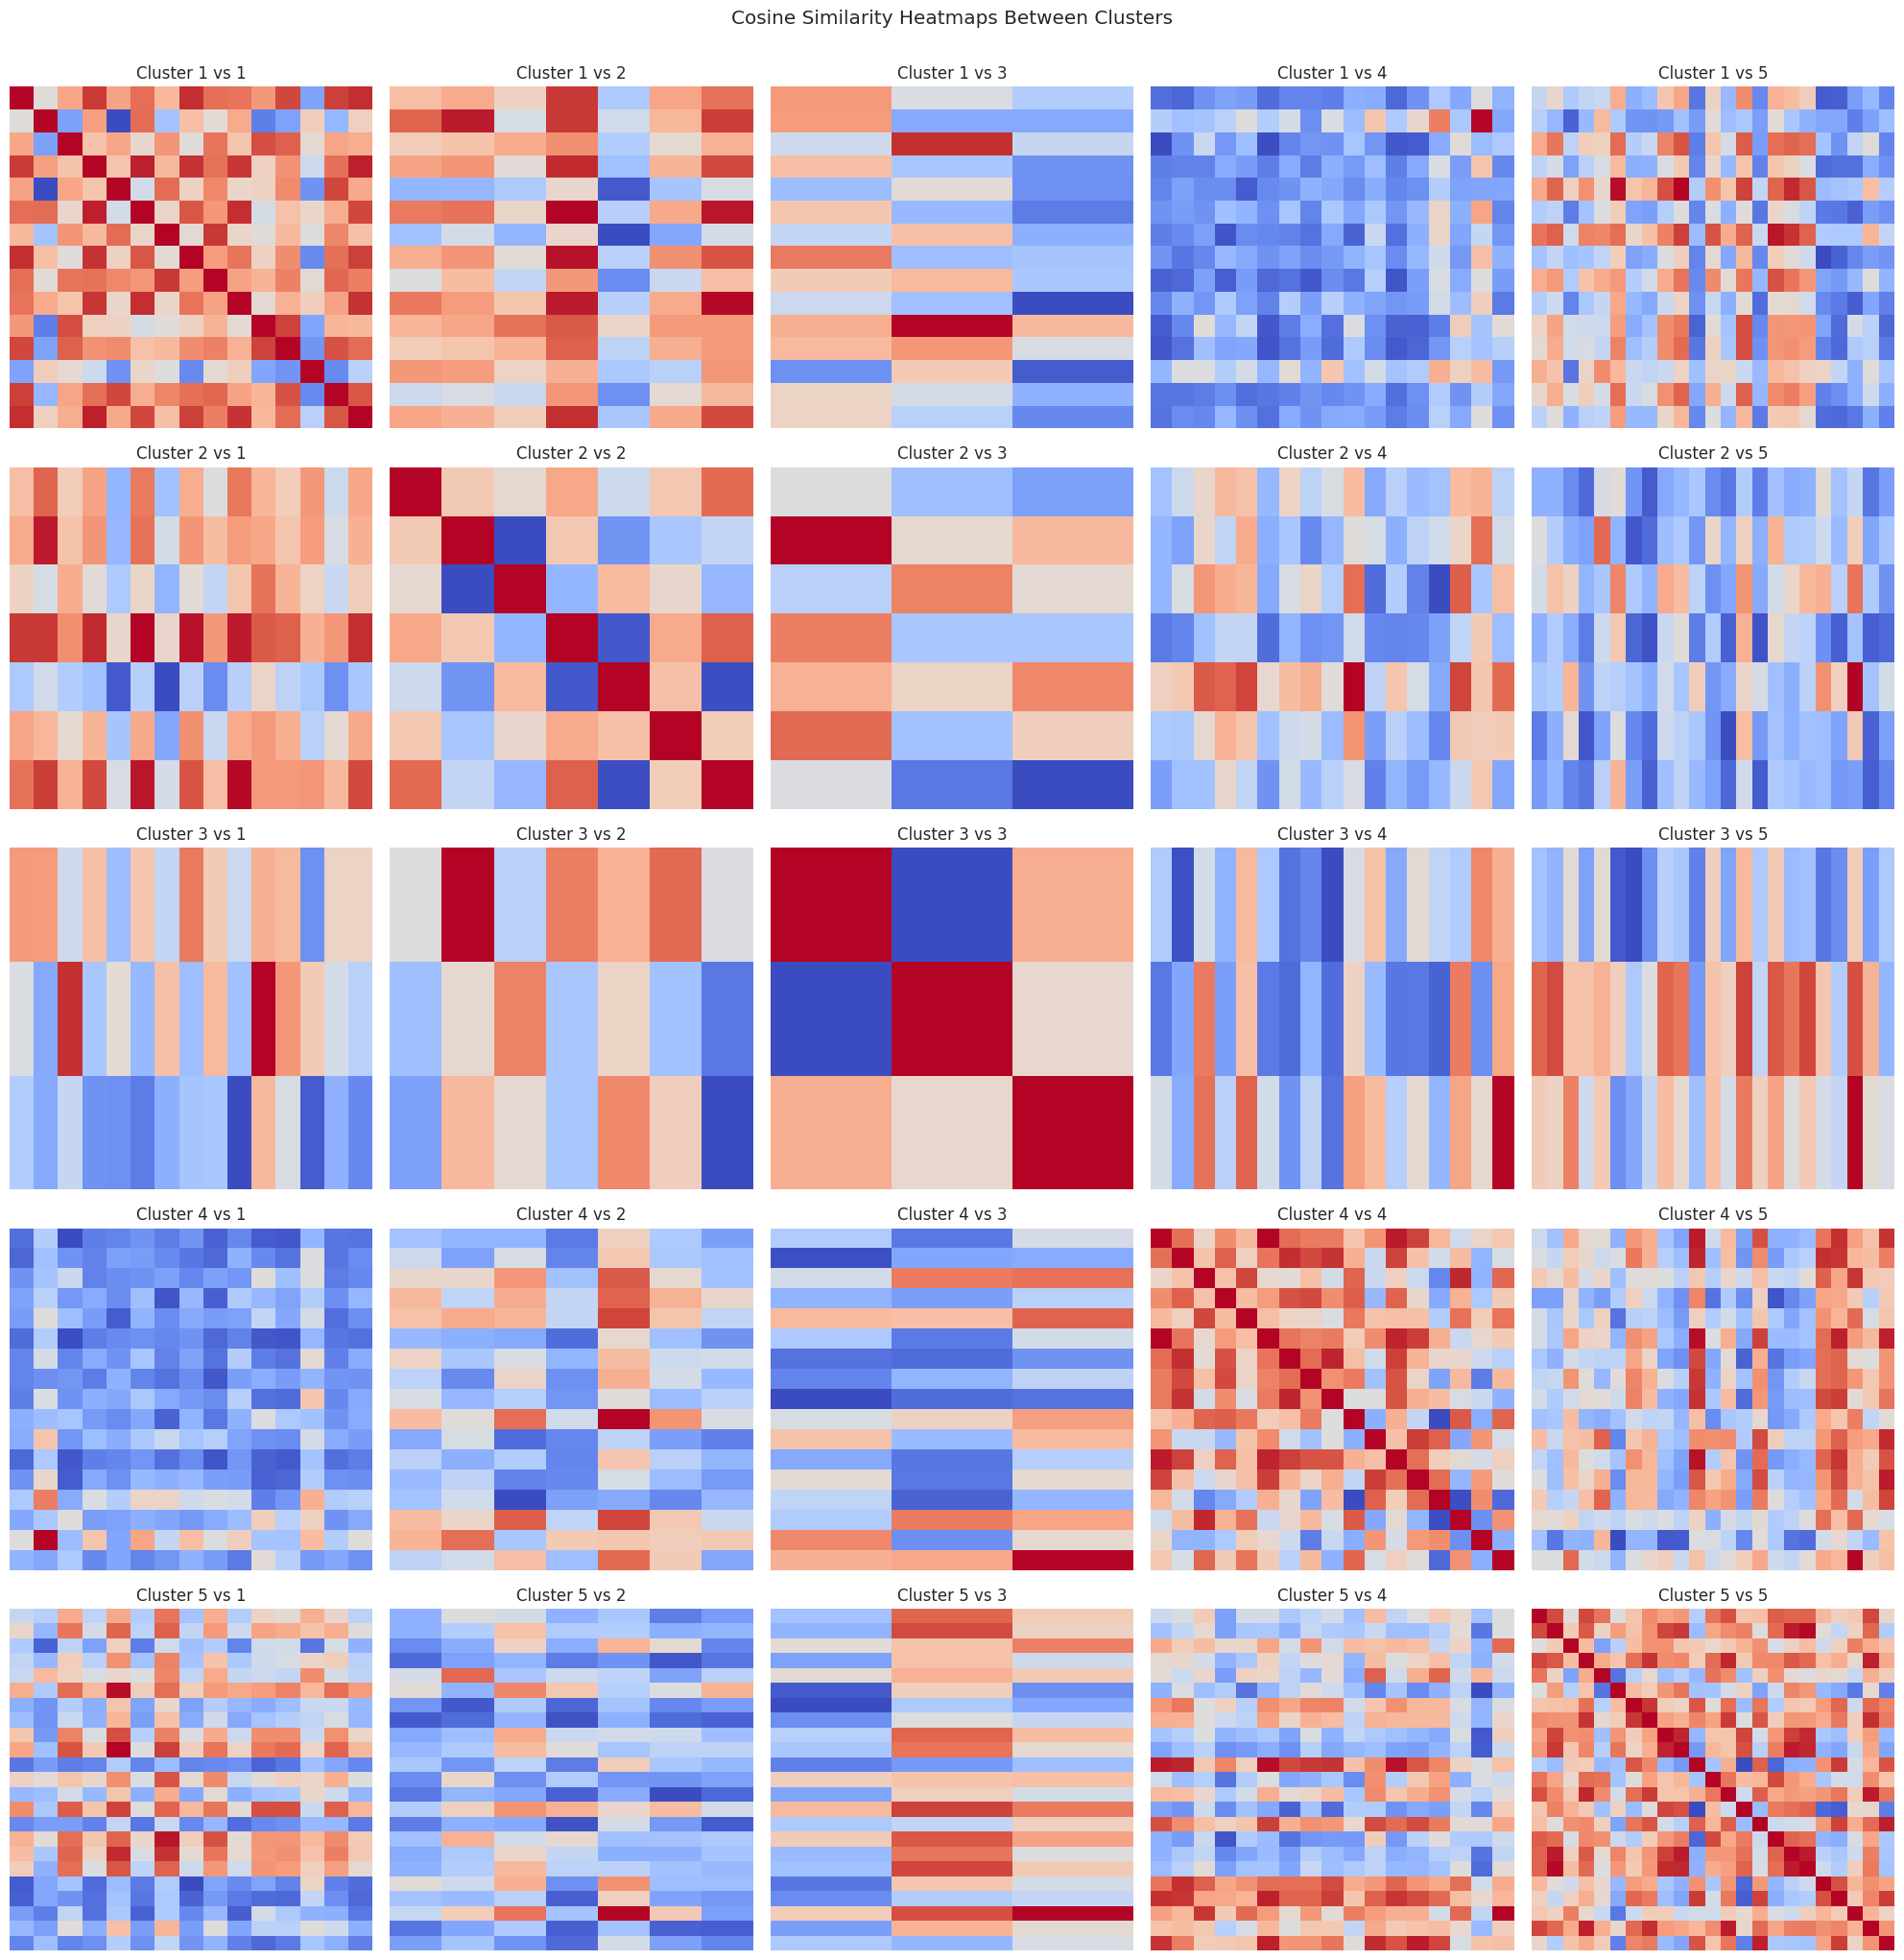

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

feature_cols = df[num_cols].drop(columns='cluster').columns.tolist()
clusters = sorted(df['cluster'].unique())
n_clusters = len(clusters)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)
df_scaled['cluster'] = df['cluster'].values

fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(4*n_clusters, 4*n_clusters))

for i, cluster_i in enumerate(clusters):
    for j, cluster_j in enumerate(clusters):
        ax = axes[i, j]

        group_i = df_scaled[df_scaled['cluster'] == cluster_i].drop(columns='cluster').values
        group_j = df_scaled[df_scaled['cluster'] == cluster_j].drop(columns='cluster').values

        sim_matrix = cosine_similarity(group_i, group_j)

        sns.heatmap(sim_matrix,
                    ax=ax,
                    cmap='coolwarm',
                    cbar=False,
                    xticklabels=False,
                    yticklabels=False)
        ax.set_title(f'Cluster {cluster_i} vs {cluster_j}')

plt.tight_layout()
plt.suptitle("Cosine Similarity Heatmaps Between Clusters", y=1.02)
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/filtered_features.csv')

print("Columns:", df.columns)

cluster_groups = df.groupby('cluster')['filename'].apply(list)

for cluster_id in range(1, 6):
    filenames = cluster_groups.get(cluster_id, [])
    print(f"\nCluster {cluster_id} — {len(filenames)} files:")
    for f in filenames:
        print(f"  {f}")


Columns: Index(['filename', 'lifetime_std', 'sphericity', 'centroid_shift',
       'num_strong_patches', 'entropy_per_pixel', 'cluster'],
      dtype='object')

Cluster 1 — 15 files:
  WT_ROI_img0070_ROI_5.csv
  WT_ROI_img0070_ROI_10.csv
  WT_ROI_img0070_ROI_11.csv
  WT_ROI_img0070_ROI_13.csv
  WT_ROI_img0073_ROI_3.csv
  WT_ROI_img0075_ROI_1.csv
  WT_ROI_img0075_ROI_5.csv
  WT_ROI_img0075_ROI_9.csv
  WT_ROI_img0076_ROI_3.csv
  WT_ROI_img0076_ROI_6.csv
  WT_ROI_img0076_ROI_10.csv
  WT_ROI_img0076_ROI_12.csv
  WT_ROI_img0079_ROI_1.csv
  WT_ROI_img0079_ROI_3.csv
  WT_ROI_img0079_ROI_8.csv

Cluster 2 — 7 files:
  WT_ROI_img0070_ROI_7.csv
  WT_ROI_img0073_ROI_4.csv
  WT_ROI_img0073_ROI_8.csv
  WT_ROI_img0075_ROI_2.csv
  WT_ROI_img0076_ROI_8.csv
  WT_ROI_img0079_ROI_10.csv
  WT_ROI_img0079_ROI_13.csv

Cluster 3 — 3 files:
  WT_ROI_img0070_ROI_12.csv
  WT_ROI_img0076_ROI_7.csv
  WT_ROI_img0076_ROI_9.csv

Cluster 4 — 17 files:
  WT_ROI_img0070_ROI_3.csv
  WT_ROI_img0070_ROI_6.csv
  WT_ROI_img0

In [ ]:
import pandas as pd
import os
import shutil

csv_path = "/content/drive/MyDrive/filtered_features.csv"
source_folder = "/content/drive/MyDrive/biocondensate images"
output_root = "/content/drive/MyDrive/normalized_sorted_clusters"

df = pd.read_csv(csv_path)

assert 'filename' in df.columns and 'cluster' in df.columns, "CSV must have 'filename' and 'cluster' columns"

for cluster_id, group in df.groupby('cluster'):
    cluster_folder = os.path.join(output_root, f"cluster_{cluster_id}")
    os.makedirs(cluster_folder, exist_ok=True)

    print(f"📂 Processing Cluster {cluster_id} with {len(group)} files...")

    for csv_name in group['filename']:
        png_name = os.path.splitext(csv_name)[0] + '.png'
        src_path = os.path.join(source_folder, png_name)

        if os.path.exists(src_path):
            shutil.copy(src_path, os.path.join(cluster_folder, png_name))
        else:
            print(f"⚠️ File not found: {src_path}")


📂 Processing Cluster 1 with 15 files...
📂 Processing Cluster 2 with 7 files...
📂 Processing Cluster 3 with 3 files...
📂 Processing Cluster 4 with 17 files...
📂 Processing Cluster 5 with 23 files...


Tried using logistic regression to predict the pole or no pole but it kind of sucked. most likely because of the lack of data.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/filtered_features_with_cluster_pos.csv")

df.columns = df.columns.str.strip()

df["Cluster_Position"] = df["Cluster_Position"].map({"pole": 1, "lateral": 0})

selected_features = [
    "lifetime_std",
    "centroid_shift",
    "sphericity",
    "num_strong_patches",
    "entropy_per_pixel"
]

X = df[selected_features]
y = df["Cluster_Position"]

clf = make_pipeline(StandardScaler(), LogisticRegression())

from sklearn.model_selection import LeaveOneOut, cross_val_score


scores = cross_val_score(clf, X, y, cv=5)
print(f"CV accuracy: {scores.mean():.3f}")


clf.fit(X, y)
model = clf.named_steps["logisticregression"]

coef_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)


print("\n Logistic Regression Feature Coefficients:")
print(coef_df)

y_pred = clf.predict(X)
print("\n Classification Report (on full data):")
print(classification_report(y, y_pred, target_names=["No Pole", "Pole"]))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CV accuracy: 0.508

 Logistic Regression Feature Coefficients:
              Feature  Coefficient
3  num_strong_patches    -0.686883
2          sphericity    -0.381103
0        lifetime_std    -0.237218
4   entropy_per_pixel    -0.104868
1      centroid_shift    -0.076186

 Classification Report (on full data):
              precision    recall  f1-score   support

     No Pole       0.59      0.56      0.58        34
        Pole       0.55      0.58      0.56        31

    accuracy                           0.57        65
   macro avg       0.57      0.57      0.57        65
weighted avg       0.57      0.57      0.57        65



In [ ]:
pd.crosstab(df["cluster"], df["Cluster_Position"])

Cluster_Position,0,1
cluster,,
1,9,6
2,4,3
3,1,2
4,9,8
5,11,12


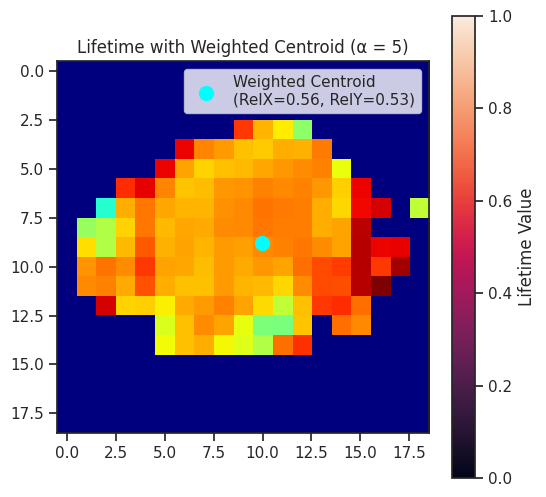

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, filters
import pandas as pd

csv_path = "/content/drive/MyDrive/roi_files/WT_ROI_img0070_ROI_8.csv"
roi = pd.read_csv(csv_path, header=None).values.astype(float)

threshold = filters.threshold_otsu(roi)
mask = roi > threshold
labeled = measure.label(mask)

alpha = 5
roi_weighted = roi ** alpha

region = max(measure.regionprops(labeled, intensity_image=roi_weighted), key=lambda r: r.area)

minr, minc, maxr, maxc = region.bbox
roi_width = maxc - minc
roi_height = maxr - minr

wcx = region.weighted_centroid[1]
wcy = region.weighted_centroid[0]
relative_x = (wcx - minc) / (roi_width - 1)
relative_y = (wcy - minr) / (roi_height - 1)

plt.figure(figsize=(6, 6))
plt.imshow(roi, cmap='jet')
plt.scatter(wcx, wcy, color='cyan', s=100, label=f'Weighted Centroid\n(RelX={relative_x:.2f}, RelY={relative_y:.2f})')
plt.title(f"Lifetime with Weighted Centroid (α = {alpha})")
plt.colorbar(label="Lifetime Value")
plt.legend()
plt.grid(False)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


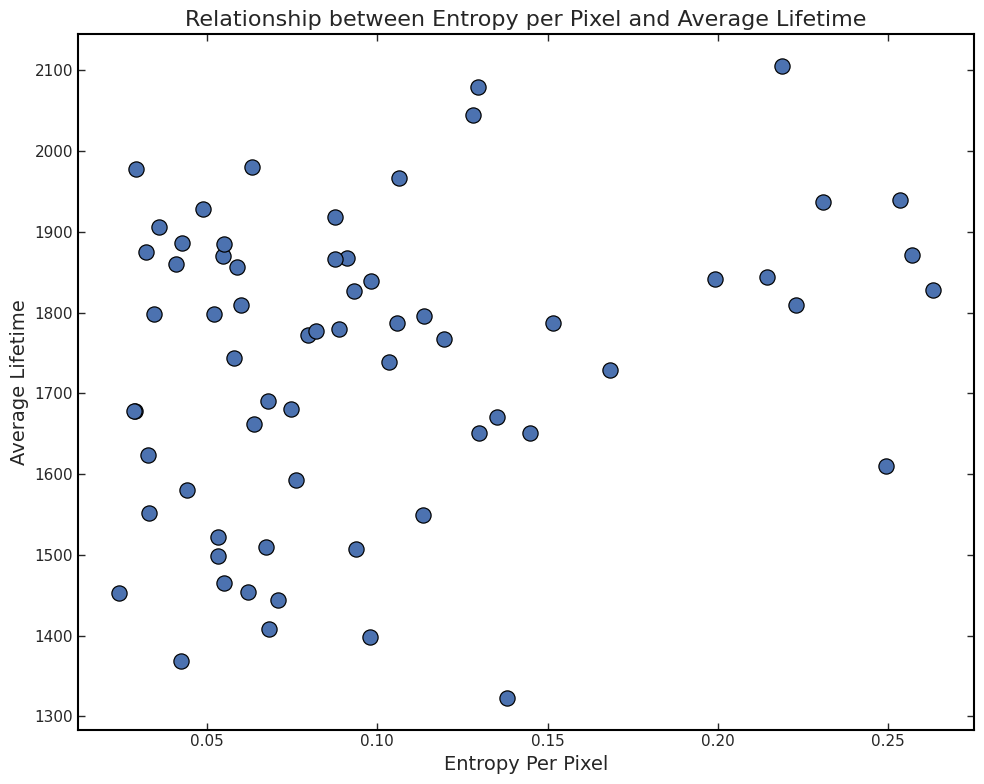

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/help.csv"
df = pd.read_csv(csv_path)

plt.figure(figsize=(10, 8))
sns.set(style="white")

scatter = sns.scatterplot(
    data=df,
    x="entropy_per_pixel",
    y="mean_lifetime",
    s=120,
    edgecolor='black'
)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tick_params(
    axis='both',
    which='both',
    direction='in',
    length=5,
    width=1,
    bottom=True, top=True, left=True, right=True
)

plt.xlabel("Entropy Per Pixel", fontsize=14)
plt.ylabel("Average Lifetime", fontsize=14)
plt.title("Relationship between Entropy per Pixel and Average Lifetime", fontsize=16)

plt.tight_layout()

output_path = "/content/drive/MyDrive/entropy_vs_lifetime.png"
plt.savefig(output_path, dpi=300)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


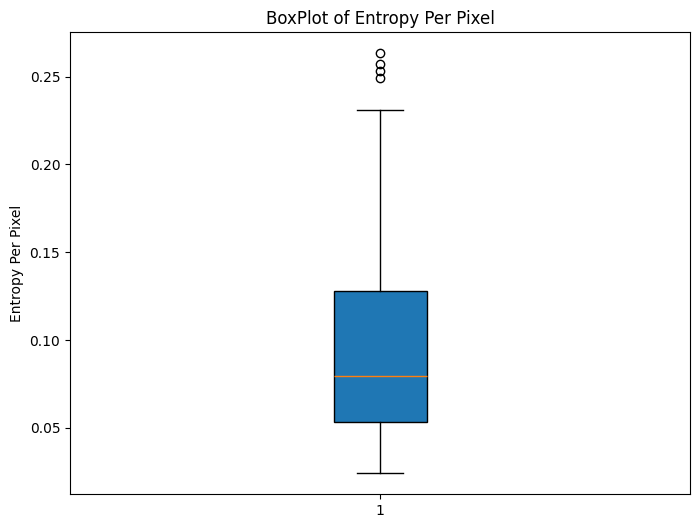

25th percentile (Q1): 0.0531913085166699
Median (Q2): 0.0796392792173067
75th percentile (Q3): 0.1280205363226648


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/help.csv')
plt.figure(figsize=(8,6))
plt.boxplot(df['entropy_per_pixel'].dropna(), vert=True, patch_artist=True)

plt.title('BoxPlot of Entropy Per Pixel')
plt.ylabel('Entropy Per Pixel')

plt.savefig('/content/drive/MyDrive/entropy_per_pixel_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

q1 = df['entropy_per_pixel'].quantile(0.25)
median = df['entropy_per_pixel'].median()
q3 = df['entropy_per_pixel'].quantile(0.75)

print(f"25th percentile (Q1): {q1}")
print(f"Median (Q2): {median}")
print(f"75th percentile (Q3): {q3}")

